<b> Standard imports for playing with and plotting data frames. </b>

In [35]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest
import random

<b> Import CPTAC data </b>

In [36]:
import CPTAC

In [37]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

random.seed(0)

## Get the patients who have mutations in both PTEN and PIK3CA 

In [38]:
#create a dataframe with both mutations included 

mutation_1 = 'PIK3CA'
mutation_2 = 'PTEN'
common_mutated = somatic_mutations.loc[(somatic_mutations['Gene'] == mutation_1) | (somatic_mutations['Gene'] == mutation_2)]

mutations_first = somatic_mutations.loc[(somatic_mutations['Gene'] == mutation_1)]
#print(mutations_first['Clinical_Patient_Key'])

patients_first = mutations_first['Clinical_Patient_Key']
first_list = patients_first.tolist()
mutations_second = somatic_mutations.loc[somatic_mutations['Gene'] == mutation_2]
#print(mutations_second)
patients_second = mutations_second['Clinical_Patient_Key']
second_list = patients_second.tolist()

#get the number of unique patients in the pik3ca mutation list
unique_1 = list()
for person in first_list:
    if person not in unique_1:
        unique_1.append(person)

#check for the overlaps 
common_list = list()
for person in second_list:
    if person in unique_1:
        if person not in common_list:
            common_list.append(person)

print(len(common_list))
#print(common_list)

41


# Compare AKT1 Phosphoproteomics 

### Create a dataframe showing PTEN and PIK3CA mutations 

In [39]:
def combine_dataframes(gene_1, gene_2, site):

    #create a dataframe for PIK3CA mutations
    phosdf_pik = CPTAC.compare_mutations(phos, site, gene_1)
    phosdf_pik = phosdf_pik.rename(index=str, columns={'Mutation' : 'Gene_1_Mutation'})

    #create a dataframe for PTEN mutations
    phosdf_pten = CPTAC.compare_mutations(phos, site, gene_2)
    phosdf_pten = phosdf_pten.rename(index=str, columns={'Mutation' : 'Gene_2_Mutation'})

    #extract the mutation column in PTEN that will be added to a combined dataframe
    pten_col = phosdf_pten['Gene_2_Mutation']

    #add the PTEN column to create a combined dataframe 
    phos_combined = phosdf_pik
    phos_combined['Gene_2_Mutation'] = pten_col

    #create new column to indicate if patient has mutations in both PIK3CA and PTEN
    phos_combined['Both_Mutations'] = False
    phos_combined.loc[common_list, 'Both_Mutations'] = True
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') & (phos_combined['Gene_2_Mutation'] == 'Wildtype'), 'Both_Mutations'] = 'Wildtype'
    #phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') | (phos_combined['Gene_2_Mutation'] == 'Wildtype') ]
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') & (phos_combined['Gene_2_Mutation'] != 'Wildtype'), 'Both_Mutations'] = (gene_2 + '_Only')
    #print(phos_combined)
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] != 'Wildtype') & (phos_combined['Gene_2_Mutation'] == 'Wildtype'), 'Both_Mutations'] =  (gene_1 + '_Only')
    #print(phos_combined)
    #take out the control
    phos_combined.loc[phos_combined['Patient_Type'] == 'Normal', 'Both_Mutations'] = 'Normal'
    
    return phos_combined


### Both Mutations vs. Non-tumor

In [40]:
gene_1 = 'PIK3CA'
gene_2 = 'PTEN'
protein = 'AKT1'

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)


#phos_df = phos_df['Patient_Type'].dropna(axis=0)
for site in phos_df.columns:
    if (site is not 'Mutation' and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site)
        #print(sitedf)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis = 0)
        #print(mutateddf)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Normal')].dropna(axis = 0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        #else: print("Unsignificant Results" , site, " ", ttest[1])



AKT1-S124   3.0973830825097156e-09
AKT1-S126   7.200404066034409e-07
AKT1-S129   1.639942257243254e-08
AKT1S1-S108   6.808557683501523e-05
AKT1S1-S112   0.001083569901724981
AKT1S1-S203   4.958249091904489e-05


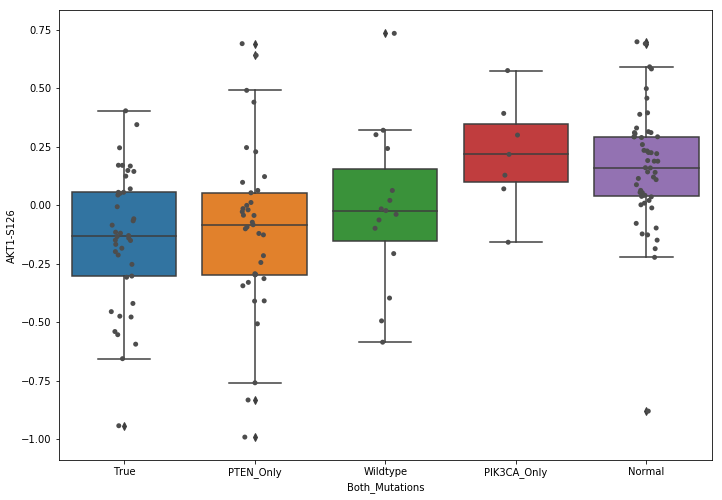

In [41]:
site = 'AKT1-S126'
sitedf = combine_dataframes(gene_1, gene_2, site)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = sitedf, x = 'Both_Mutations', y = site)
boxplt = sns.stripplot(data = sitedf, x = 'Both_Mutations', y = site, jitter = True, color = '.3')
plt.show()

### Both Mutations vs. Wildtype_1 (PTEN Mutations Only)

In [42]:


phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    #print("site: ", site)
    if (site is not 'Mutation' and site is not 'Patient_Type'):
        #print(site)
        sitedf = combine_dataframes(gene_1, gene_2,  site)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis = 0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_2 + '_Only'))].dropna(axis = 0)
        #print(wtdf)
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        #else: print("Unsignificant Results" , site, " ")



### Both Mutations vs. Wildtype_2 (PIK3CA Mutations Only)

In [43]:


phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)
#print(cutoff)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2, site)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_1 + '_Only'))].dropna(axis=0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




### Wildtype_1 vs. Wildtype_2 (PTEN Mutations Only v PIK3CA Mutations Only)

In [44]:

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == (gene_1 + '_Only')].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_2 + '_Only'))].dropna(axis=0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




### Both Mutations vs. Wildtype (No PTEN or PIK3CA mutations)

In [45]:

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Wildtype')].dropna(axis=0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




# Protein Abundance Comparison

In [46]:
gene_1 = 'PIK3CA'
gene_2 = 'PTEN'
protein = 'AKT1'

prot_df = CPTAC.compare_mutations(proteomics, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(prot_df.columns)


        
sitedf = combine_dataframes(gene_1, gene_2,  protein)
        
mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis = 0)
        
wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Normal')].dropna(axis = 0)
print(wtdf)

if site in wtdf.columns and site in mutateddf.columns:
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
    if ttest[1] < cutoff:
        print(site, " ", ttest[1])
        #else: print("Unsignificant Results" , site, " ", ttest[1])


Empty DataFrame
Columns: [AKT1-S122, AKT1-S124, AKT1-S126, AKT1-S129, AKT1-T450, AKT1S1-S108, AKT1S1-S112, AKT1S1-S203, AKT1S1-S222, AKT1S1-S223, AKT1S1-S231, AKT1S1-S232, AKT1S1-S241, AKT1S1-S267, AKT1S1-T110, AKT1S1-T117, AKT1S1-T218, AKT1S1-T266, AKT1S1-T93, Gene_1_Mutation, Patient_Type, Gene_2_Mutation, Both_Mutations]
Index: []

[0 rows x 23 columns]
